# Lung inflammation v1

Publication: [Deep neural network based histological scoring of lung fibrosis and inflammation in the mouse model system](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0202708) ([dataset](https://osf.io/28qbc/))<br>
Benchmark: lung inflammation final accuracy 0.80

## Notebook setup

In [1]:
## notebook setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import fastai
from fastai import *
from fastai.vision import *

## Data setup

In [3]:
!pwd

/home/paperspace/lung


In [4]:
# main path
path = Path('/home/paperspace/fastai/data/lung'); path

PosixPath('/home/paperspace/fastai/data/lung')

In [5]:
# training datasets paths
path_train_0 = path/'lung_inflammation/training/0'
path_train_1 = path/'lung_inflammation/training/1'
path_train_2 = path/'lung_inflammation/training/2'
path_train_3 = path/'lung_inflammation/training/3'
path_train_4 = path/'lung_inflammation/training/ignore'

In [6]:
path_train = [path_train_0, path_train_1, path_train_2, path_train_3, path_train_4]

In [7]:
# validation dataset path
path_valid_0 = path/'lung_inflammation/val/0'
path_valid_1 = path/'lung_inflammation/val/1'
path_valid_2 = path/'lung_inflammation/val/2'
path_valid_3 = path/'lung_inflammation/val/3'
path_valid_4 = path/'lung_inflammation/val/ignore'

In [8]:
path_valid = [path_valid_0, path_valid_1, path_valid_2, path_valid_3, path_valid_4]

In [9]:
# view png images in directory
#import glob
#glob.glob(str(path_train_0/'*.png'))

In [10]:
# load image url, train/valid information, and class from folder structure
import glob

# load train images
for i, l in enumerate(path_train):
    if i == 0:
        df = pd.DataFrame({'imgurl': glob.glob(str(l/'*.png')), 'train/valid':'train', 'class': i})
    else:
        df = df.append(pd.DataFrame({'imgurl': glob.glob(str(l/'*.png')), 'train/valid':'train', 'class': i}))
        
# load valid images
for i, l in enumerate(path_valid):
    df = df.append(pd.DataFrame({'imgurl': glob.glob(str(l/'*.png')), 'train/valid':'valid', 'class': i}))

# reset index
df = df.reset_index()
df = df.drop('index', 1) # comment to keep original index

# remove path from imgurl
f = lambda x: x.split('/', 6)[-1]
df['imgurl'] = df['imgurl'].apply(f)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4700 entries, 0 to 4699
Data columns (total 3 columns):
imgurl         4700 non-null object
train/valid    4700 non-null object
class          4700 non-null int64
dtypes: int64(1), object(2)
memory usage: 110.2+ KB


In [12]:
df.head()

,imgurl,train/valid,class
0,lung_inflammation/training/0/16_314_42_29_19.png,train,0
1,lung_inflammation/training/0/16_314_23_3_14.png,train,0
2,lung_inflammation/training/0/17_305_01_11_20.png,train,0
3,lung_inflammation/training/0/16_314_23_5_7.png,train,0
4,lung_inflammation/training/0/16_314_36_19_32.png,train,0


In [13]:
df.tail()

,imgurl,train/valid,class
4695,lung_inflammation/val/ignore/16_314_13_10_11.png,valid,4
4696,lung_inflammation/val/ignore/17_305_17_10_21.png,valid,4
4697,lung_inflammation/val/ignore/17_305_02_8_32.png,valid,4
4698,lung_inflammation/val/ignore/16_314_58_25_34.png,valid,4
4699,lung_inflammation/val/ignore/16_314_11_7_24.png,valid,4


In [14]:
bs = 32
size = 224

In [15]:
data = ImageDataBunch.from_df(path, df[['imgurl', 'class']], df_tfms=get_transforms(), size=size, bs=bs)

In [16]:
data.normalize(imagenet_stats);

## Data exploration

In [17]:
path_train_0/'17_305_28_24_46.png'

PosixPath('/home/paperspace/fastai/data/lung/lung_inflammation/training/0/17_305_28_24_46.png')

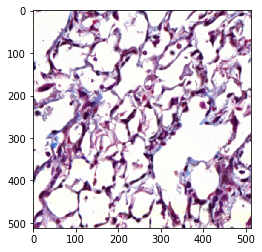

In [18]:
# "sampleId_secondarySampleId_x_y.png" (from https://osf.io/jenyr/)
img = plt.imread('/home/paperspace/fastai/data/lung/lung_inflammation/training/0/17_305_28_24_46.png')
plt.imshow(img)

In [38]:
# TO BE CONTINUED!

## Setup model

In [19]:
!gpustat

psbtmxtmo  Tue Oct 30 16:00:25 2018
[0] Quadro P4000     | 39'C,   0 % |    10 /  8119 MB |


In [20]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [21]:
!gpustat

psbtmxtmo  Tue Oct 30 16:00:29 2018
[0] Quadro P4000     | 39'C,   3 % |   599 /  8119 MB | paperspace(589M)


## Training

### Stage 1 - Training of new head

In [22]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


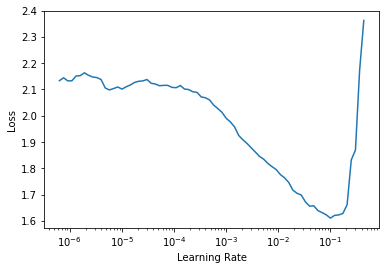

In [23]:
learn.recorder.plot()

In [24]:
lr = 1e-3

In [25]:
learn.fit_one_cycle(1, max_lr=lr)

Total time: 01:19
epoch  train_loss  valid_loss  accuracy
1      1.063883    0.715193    0.703057  (01:19)



In [26]:
learn.fit_one_cycle(3, max_lr=lr)

Total time: 03:47
epoch  train_loss  valid_loss  accuracy
1      0.801068    0.671646    0.727074  (01:15)
2      0.679883    0.592823    0.755459  (01:16)
3      0.588713    0.583016    0.756550  (01:15)



In [27]:
learn.fit_one_cycle(3, max_lr=lr)

Total time: 03:48
epoch  train_loss  valid_loss  accuracy
1      0.541555    0.627346    0.762009  (01:16)
2      0.507908    0.575570    0.769651  (01:16)
3      0.403622    0.583232    0.764192  (01:16)



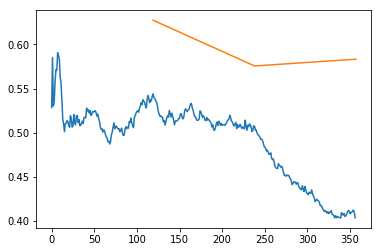

In [28]:
learn.recorder.plot_losses()

In [29]:
learn.save('lung_inf_stage_1_20181030_v1')

### Stage 2 - Training of entire network

In [30]:
learn.load('lung_inf_stage_1_20181030_v1')

In [31]:
learn.unfreeze()

In [32]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


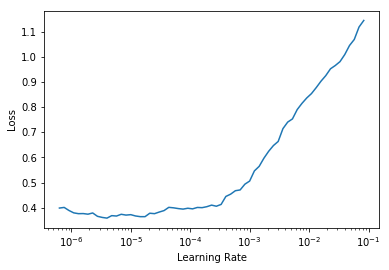

In [33]:
learn.recorder.plot()

In [34]:
lr=1e-6

In [36]:
learn.fit_one_cycle(1, max_lr=lr)

Total time: 01:41
epoch  train_loss  valid_loss  accuracy
1      0.395040    0.573365    0.772926  (01:41)



In [37]:
learn.fit_one_cycle(3, max_lr=lr)

Total time: 05:04
epoch  train_loss  valid_loss  accuracy
1      0.368811    0.577525    0.765284  (01:40)
2      0.374630    0.575405    0.767467  (01:41)
3      0.345230    0.578508    0.764192  (01:42)



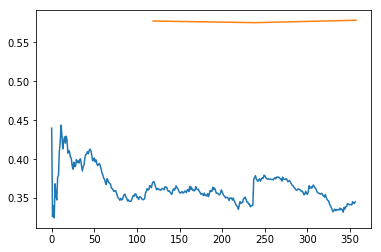

In [39]:
learn.recorder.plot_losses()

In [41]:
learn.save('lung_inf_stage_2_20181030_v1')

In [42]:
learn.load('lung_inf_stage_2_20181030_v1')

## Interpretation

In [43]:
interp = ClassificationInterpretation.from_learner(learn)

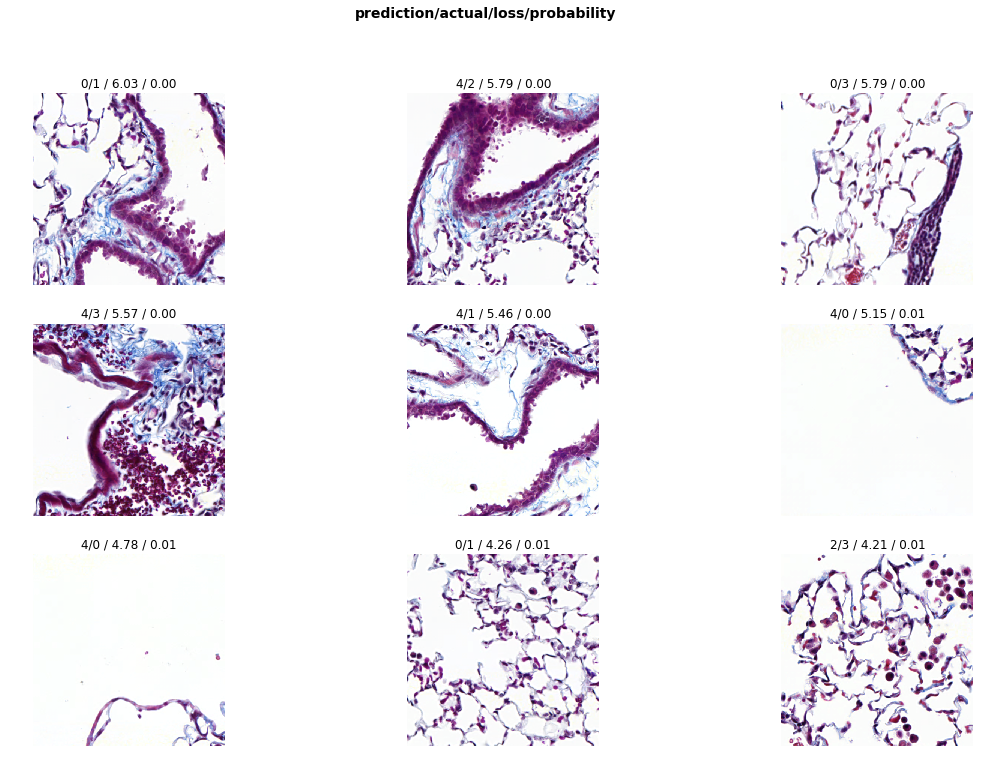

In [44]:
interp.plot_top_losses(9, figsize=(19,12))

In [55]:
interp.confusion_matrix()

array([[305,  36,   6,   1,   6],
       [ 30,  90,  24,   8,   3],
       [  3,  36,  45,  12,   1],
       [  2,   5,  17,  58,   6],
       [ 14,   2,   3,   1, 202]])

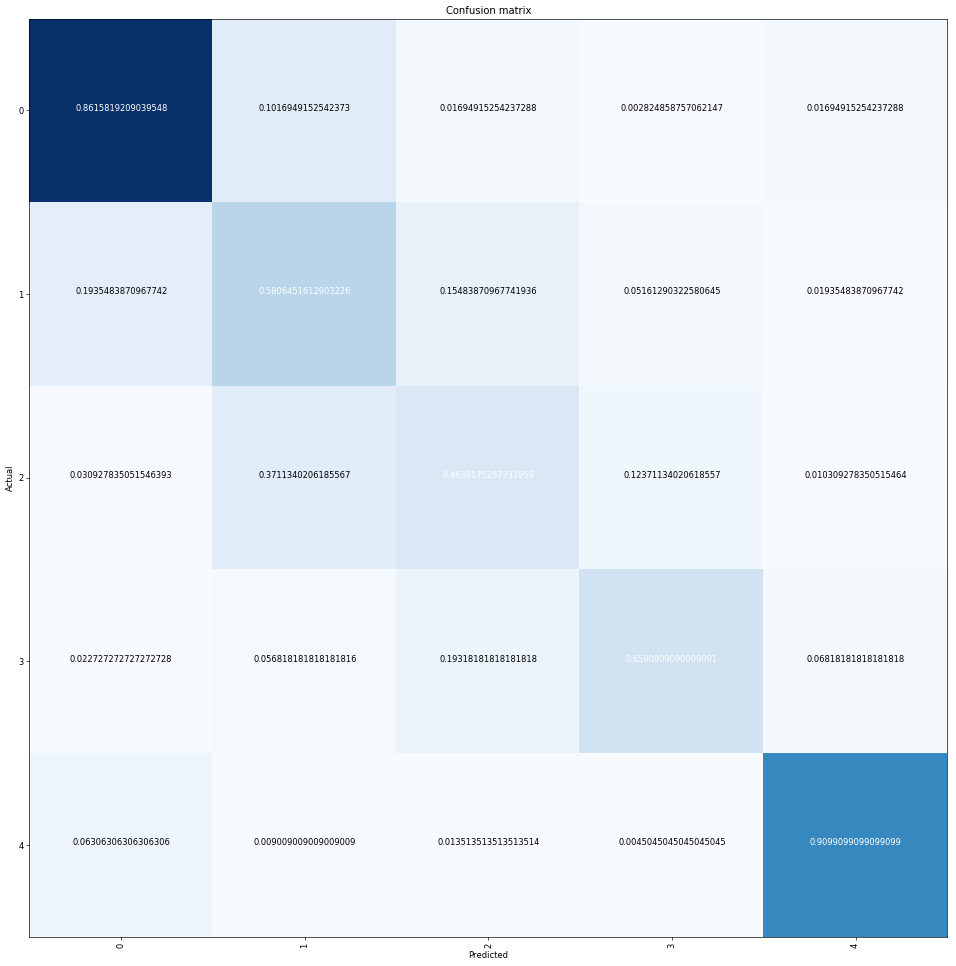

In [54]:
interp.plot_confusion_matrix(figsize=(16,16), dpi=60, normalize=True)